# Few-shot semantic segmentation for PV suitability assessment

### Memo


This notebook offers an in-depth look at few-shot learning (FSL), an advanced deep learning technique that enables models to generalize effectively from only a small number of training examples. FSL becomes particularly valuable when traditional supervised learning is impractical. For instance, when annotation is expensive, requires specialized expertise, or when data is scarce.  
Few-shot learning is especially relevant in the context of public policy, where we often face limited access to comprehensive, well-curated datasets or lack the resources to collect large amounts of training data. Applications span a wide range of policy areas, including disaster classification (Lee et al., 2025), urban planning (Hu et al., 2022) and health policy, where FSL has supported COVID-19 detection (Jadon, 2021) and the diagnosis of rare genetic diseases (Alsentzer et al., 2025).  
Beyond classification tasks, FSL also performs well in segmentation problems, helping identify different types of buildings, vegetation such as forest cover (Puthumanaillam & Verma, 2023) and performing well in remote sensing imagery segmentation (Chen et al., 2022).All of these examples share a common challenge: limited data. Few-shot learning helps address this constraint, and we encounter similar situations within our own institution. A clear illustration is our Wildlife Trade Monitoring Project (WTMP), where labeled examples of rare, endangered species are extremely scarce and often inconsistent. This emphasizes just how valuable few-shot learning approaches can be.  
Today, a wide range of few-shot learning frameworks and architectures are available. Some of the most widely used include model-agnostic meta-learning (Finn, Abbeel & Levine, 2017), prototypical networks (Snell, Swersky & Zemel, 2017), and relation networks (Sung et al., 2018). Over the past few years, the field has continued to evolve, giving rise to more specialized and state-of-the-art techniques, such as SegPPD-FS for semantic segmentation (Ge et al., 2025) and CDCNet for classification tasks (Li et al., 2025).   
Because of its importance to public policy and its potential value for our organization, this notebook takes a deep dive into prototypical networks semantic segmentation of building rooftops. This is an essential step for many downstream tasks, such as assessing rooftop suitability for solar panel installation. By walking through this method, the notebook aims to help our staff better understand and apply this powerful technique in their day-to-day work.

---

### Introduction

Dear colleagues,  
In this notebook, we will introduce the concept of few-shot learning (FSL). As briefly mentioned earlier, FSL is an advanced deep learning paradigm that enables models to generalize from only a handful of annotated samples. In particular, we will focus on prototypical networks, which learn a metric space where each class is represented by a prototype (usually the mean embedding of its support examples) and then classify query samples based on their distance to these prototypes (more details will be provided below). This method can be applied to semantic segmentation tasks, allowing us to partition an image into meaningful regions.
To guide you through this approach, we will work with the Geneva Satellite Images dataset. This dataset contains high-resolution (250×250 PNG tiles) satellite imagery of Geneva, Switzerland, along with pixel-level segmentation masks that delineate building rooftops. It was developed by EPFL’s Solar Energy and Building Physics Laboratory and is publicly available on [HuggingFace](https://huggingface.co/datasets/raphaelattias/overfitteam-geneva-satellite-images)
 (Castello et al., 2021).  
The goal of this notebook is to demonstrate how few-shot learning can be used for rooftop semantic segmentation, with applications such as assessing the suitability of buildings for solar panels.  

Throughout the notebook, we will walk you through how to:  

- Load and preprocess satellite imagery
- Build a few-shot segmentation model
- Train the model using prototypical networks
- Evaluate segmentation performance  
  
Your task is to follow the code and understand how to apply few-shot learning to detect rooftops in new satellite images using only a few labeled examples. You can run each cell in sequence. At every step, we provide clear explanations of what is happening. A pre-recorded video is also available if you prefer a more visual learning format.  

If you have any questions about few-shot learning or need help with its implementation, please feel free to reach out. Our contact information is provided above.  
 
Happy learning!  

Your Public Innovation Lab (PILAB)  


---

### Task description


- **Binary semantic segmentation** problem: for each pixel in a satellite tile, we predict whether it is part of a rooftop suitable for photovoltaics (PV) or background.
- The method is based on **prototypical networks for segmentation**: we learn an encoder that maps pixels into an embedding space and then classify each pixel by its distance to simple “prototypes” built from a small number of labeled support images. 

Instead of training a standard segmentation network on a fully labeled dataset, we:

- Meta-train an encoder on “episodes” that takes 1 support image + mask → learn prototypes → segment a query image.
- At test time we can feed the model K labeled examples (K-shot) for a new set of tiles and segment unseen images with limited supervision.

---

## Notebook structure

1. **Setup**: install packages and import dependencies  
2. **Data download**: fetch the Geneva rooftop dataset from Hugging Face  
3. **Base dataset**: load images and binary rooftop masks with transforms  
4. **Visualizaion**: visualise a sample image + mask  
5. **Few-shot episodes**: build an episodic dataset (support + query pairs)  
6. **Encoder**: ResNet-based convolutional feature extractor  
7. **Prototypes & classification**: compute foreground/background prototypes and classify pixels  
8. **Metric**: define Intersection-over-Union (IoU) for evaluation  
9. **Meta-training**: episodic training loop for the encoder  
10. **Inference & evaluation**: K-shot prediction, IoU evaluation, and visualisations


---

## 1. Setup

We first install and import the libraries needed for the tutorial:

- `torch` and `torchvision` for deep learning and pretrained vision models,
- `matplotlib`, `PIL`, and `numpy` for visualisation and array manipulation,
- `huggingface_hub` to download the rooftop dataset from the Hugging Face Hub.


In [2]:
!pip install -q huggingface_hub torch torchvision matplotlib

import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models
from huggingface_hub import snapshot_download

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


/Users/giocopp/miniconda3/envs/DL-Tutorial/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Data download: Geneva rooftop tiles

We use a small satellite dataset of building rooftops in Geneva, stored on the Hugging Face Hub. Each tile comes with:

- a **RGB satellite image**, and
- a **binary mask** indicating pixels that belong to rooftops suitable for PV installations.

Using `huggingface_hub.snapshot_download`, we download the dataset to the local filesystem.


In [3]:
dataset_root = snapshot_download(repo_id="raphaelattias/overfitteam-geneva-satellite-images", repo_type="dataset")
print("Dataset root:", dataset_root)

Fetching 2111 files: 100%|██████████| 2111/2111 [00:00<00:00, 8878.66it/s]

Dataset root: /Users/giocopp/.cache/huggingface/hub/datasets--raphaelattias--overfitteam-geneva-satellite-images/snapshots/3f90d759384e4cd38276290521b6f6b03ddfcf87


## 3. Data preprocessing

To work with PyTorch, we define a `Dataset` class that returns `(image, mask)` pairs:

- Images are resized to a fixed resolution of **256 × 256**, converted to PyTorch tensors, and normalised with **ImageNet mean and standard deviation**. This is compatible with the pretrained ResNet18 backbone we will use later. 
- Masks are resized using **nearest-neighbour interpolation** to avoid mixing labels at boundaries, converted to tensors in `[0, 1]`, and then **binarised** pixels so that any non-zero value is treated as rooftop (class 1): mask pixels can be either background or rooftop.

The `GenevaRooftopDataset` class wraps these steps and reads from a structured folder layout with `images/` and `labels/` subdirectories. We instantiate three splits: train, validation, and test. These base datasets will later feed into both standard visualisation and our few-shot episodic sampling.

> **Notice**  
> *To be changed if we do geosplits*  
> *Also, even if we don't do geosplits, we don't need the validation set*


In [4]:
IMAGE_SIZE = 256  # resize tiles to this

img_transform = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

mask_transform = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=Image.NEAREST),
        transforms.ToTensor(),  # gives float [0,1] for grayscale
    ]
)


def get_grid_id_from_filename(fname):
    parts = fname.split("_")
    # 3th and 3th parts give the grid ID
    return f"{parts[2]}_{parts[3]}"


class GenevaRooftopDataset(Dataset):
    """
    Dataset filtered by geographic grid IDs.
    Can read from multiple splits (train/val/test) at once.
    """

    def __init__(self, root, splits=["train", "val", "test"], category="all", grid_ids=None):
        super().__init__()
        self.root = root
        self.category = category
        self.grid_ids = grid_ids
        self.files_info = []  # list of tuples (split, filename)

        # Collect files from all specified splits
        for split in splits:
            image_dir = os.path.join(root, split, "images", category)
            label_dir = os.path.join(root, split, "labels", category)

            all_files = sorted([f for f in os.listdir(image_dir) if f.endswith(".png")])

            # Filter by grid_ids if provided
            if grid_ids is not None:
                all_files = [f for f in all_files if get_grid_id_from_filename(f) in grid_ids]

            # Store split info for loading
            self.files_info.extend([(split, f) for f in all_files])

    def __len__(self):
        return len(self.files_info)

    def __getitem__(self, idx):
        split, fname = self.files_info[idx]
        img_path = os.path.join(self.root, split, "images", self.category, fname)
        mask_name = fname.replace(".png", "_label.png")
        mask_path = os.path.join(self.root, split, "labels", self.category, mask_name)

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        img = img_transform(img)
        mask = mask_transform(mask)
        mask = (mask > 0.5).float()

        return img, mask


train_grids = ["1301_11", "1301_31"]
test_grids = ["1301_13"]

# Train dataset reads from all three folders
train_base = GenevaRooftopDataset(dataset_root, splits=["train", "val", "test"], grid_ids=train_grids)

# Test dataset can read from just one folder or multiple if needed
test_base = GenevaRooftopDataset(dataset_root, splits=["train", "val", "test"], grid_ids=test_grids)

print(f"Train samples: {len(train_base)}, Test samples: {len(test_base)}")

Train samples: 423, Test samples: 102


## 4. Visualization: image and mask

We verify that images and masks line up correctly, and pixel masks have the expected binary structure. The helper function below randomly draws a sample from a given dataset, undoes the image normalisation for plotting, and displays the RGB image side-by-side with its rooftop mask.


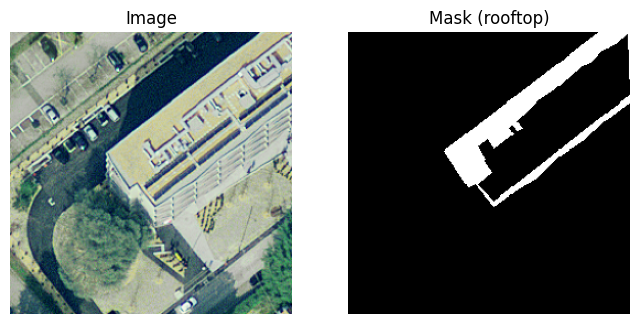

In [5]:
def show_sample(dataset, idx=None):
    if idx is None:
        idx = random.randint(0, len(dataset) - 1)
    img, mask = dataset[idx]  # img [3,H,W], mask [1,H,W]

    # Undo normalisation for plotting
    img_np = img.permute(1, 2, 0).numpy()
    img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_np = np.clip(img_np, 0, 1)

    # mask: [1, H, W] -> [H, W]
    mask_np = mask.squeeze(0).numpy()

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask_np, cmap="gray")
    plt.title("Mask (rooftop)")
    plt.axis("off")
    plt.show()


show_sample(train_base)

# 5. Methodology  

## 5.1. Few-shot episodes: support and query

Few-shot learning is typically implemented with **episodic training**. An **episode** is one small training problem that mimics how we will use the model at test time: we see some labelled examples (support) and we must make predictions for new data (query).

In this setting, each episode contains:

- a **support image with its mask** `(img_s, mask_s)`, and  
- a **query image with its mask** `(img_q, mask_q)`.

We create an `EpisodeDataset` that wraps the base training dataset. For every episode, it randomly picks two *different* tiles from the training set:

- one becomes the support pair,
- the other becomes the query pair.

During training, the model:

1. looks at the **support image + mask** to learn what rooftops and background look like, and  
2. tries to correctly segment the **query image**, using that information.

The parameter `episodes_per_epoch` defines how many such support–query pairs (episodes) we use in one training epoch. A `DataLoader` iterates over this dataset and gives us **one episode at a time** for training.


In [6]:
class EpisodeDataset(Dataset):
    """
    Yields (support_imgs [K,3,H,W], support_masks [K,1,H,W], query_img, query_mask)
    """

    def __init__(self, base_dataset, episodes_per_epoch=750, K=1):
        self.base = base_dataset
        self.episodes_per_epoch = episodes_per_epoch
        self.n = len(base_dataset)
        self.K = 1

    def __len__(self):
        return self.episodes_per_epoch

    def __getitem__(self, idx):
        # sample K support + 1 query index
        indices = random.sample(range(self.n), self.K + 1)
        *support_idx, query_idx = indices  # Python unpacking

        # get support items
        support = [self.base[i] for i in support_idx]
        imgs_s, masks_s = zip(*support, strict=False)  # tuples of tensors

        # get query item
        img_q, mask_q = self.base[query_idx]

        # stack support tensors
        imgs_s = torch.stack(imgs_s, dim=0)  # [K, 3, H, W]
        masks_s = torch.stack(masks_s, dim=0)  # [K, 1, H, W]

        return imgs_s, masks_s, img_q, mask_q


episodes_per_epoch = 2000
episode_dataset = EpisodeDataset(train_base, episodes_per_epoch=episodes_per_epoch)
episode_loader = DataLoader(episode_dataset, batch_size=1, shuffle=True)

## 5.2. Encoder backbone: ResNet18 feature extractor

We now define the feature extractor that underpins our prototypical network. The `Encoder` class:

- uses a **pretrained ResNet18** from `torchvision`,
- keeps the convolutional layers up to `layer3`, which downsample the input by a factor of 8, and
- adds a `1×1` convolution to project the ResNet features into a configurable embedding dimension (here 256 channels).

Given an input image of shape `[3, H, W]`, the encoder outputs a feature map `[C, H', W']`. These feature maps are the basis for computing class prototypes (rooftop vs background) and for classifying each pixel at test time.

> **Notice:**
> ResNet18 is lightweight and pretrained on ImageNet. We expect a model pretrained on geospatial/satellite images to perform better as feature extractor &rarr; can be a good *extension*.  
> *Question: How changing the backbone architecture changes the performance?*


In [8]:
from torchgeo.models import resnet18


class Encoder(nn.Module):
    def __init__(self, out_channels=256, pretrained=True):
        super().__init__()
        backbone = models.resnet18(pretrained=pretrained)
        self.stem = nn.Sequential(
            backbone.conv1,
            backbone.bn1,
            backbone.relu,
            backbone.maxpool,
        )
        self.layer1 = backbone.layer1
        self.layer2 = backbone.layer2
        self.layer3 = backbone.layer3

        self.proj = nn.Conv2d(128 + 256, out_channels, kernel_size=1)  # 128 from layer2, 256 from layer3

    def forward(self, x):
        x = self.stem(x)
        f1 = self.layer1(x)
        f2 = self.layer2(f1)  # [B,128,H/4,W/4]
        f3 = self.layer3(f2)  # [B,256,H/8,W/8]

        f2_up = F.interpolate(f2, size=f3.shape[-2:], mode="bilinear", align_corners=False)
        f = torch.cat([f2_up, f3], dim=1)  # [B,384,H',W']
        f = self.proj(f)
        return f


encoder = Encoder(out_channels=256).to(device)
print(encoder)

/Users/giocopp/miniconda3/envs/DL-Tutorial/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/giocopp/miniconda3/envs/DL-Tutorial/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Encoder(
  (stem): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): R

## 5.3. Prototypical segmentation: prototypes and query classification

The core idea of prototypical networks is to represent each class by a **prototype vector** in feature space and to classify new examples based on their distance to these prototypes.

For segmentation we apply this idea at the **pixel level**. In this case we have only one class (we are segmenting rooftops from background): binary case (rooftop vs non-rooftop), therefore we are using a 2-class prototypical network.

- From the support images and their masks, we compute:
  - a **foreground prototype** (rooftops),
  - and a **background prototype**,
  by performing masked average pooling over the encoder feature maps.
  
- For a query image, we run the encoder once to obtain features and then:
  - compute the squared Euclidean distance from each pixel’s feature vector to each prototype,
  - convert distances into logits (negative distances),
  - and reshape to a `[1, 2, H', W']` logit map over classes 0 (background) and 1 (rooftop).

These two functions, `compute_prototypes` and `classify_query`, implement the prototypical segmentation logic used in both training and evaluation.


In [9]:
# ============================================================
# 6. Prototype computation & query classification
# ============================================================


def compute_prototypes(feat_support, mask_support):
    """
    Compute background/foreground prototypes from multiple support images.

    feat_support: [K, C, H', W']   (K support images)
    mask_support: [K, 1, H,  W]    (binary masks)
    Returns: prototypes [2, C] (0=background, 1=foreground)
    """
    # Downsample mask to feature resolution
    mask_small = F.interpolate(
        mask_support, size=feat_support.shape[2:], mode="nearest"
    )  # Downsamples masks to feature size via nearest neighbor
    mask_fg = (mask_small > 0.5).float()  # [K,1,H',W']
    mask_bg = 1.0 - mask_fg  # [K,1,H',W']

    K, C, Hf, Wf = feat_support.shape

    # Flatten across batch and spatial dims: [K,C,H',W'] -> [C, K*H'*W']
    fs = feat_support.permute(1, 0, 2, 3).contiguous().view(C, -1)  # [C, K*H'*W']
    fg_w = mask_fg.view(1, -1)  # [1, K*H'*W']
    bg_w = mask_bg.view(1, -1)

    eps = 1e-6

    # Weighted average for foreground
    fg_proto = (fs * fg_w).sum(dim=1) / (fg_w.sum(dim=1) + eps)  # [C]
    # Weighted average for background
    bg_proto = (fs * bg_w).sum(dim=1) / (bg_w.sum(dim=1) + eps)  # [C]

    prototypes = torch.stack([bg_proto, fg_proto], dim=0)  # [2,C]
    return prototypes


def classify_query(feat_query, prototypes):
    """
    Classify query pixels by distance to prototypes.

    feat_query: [1, C, H', W']
    prototypes: [2, C]
    Returns: logits [1, 2, H', W']
    """
    B, C, Hq, Wq = feat_query.shape

    # [1,C,H',W'] -> [H'*W', C]
    fq = feat_query.view(C, -1).t()  # [H'*W', C]

    # [2, C]
    protos = prototypes  # [2,C]

    # Compute squared Euclidean distance from each pixel to each prototype
    # torch.cdist expects [B, N, D], so add batch dim
    # fq_batch: [1, H'*W', C], protos_batch: [1, 2, C]
    dists = torch.cdist(fq.unsqueeze(0), protos.unsqueeze(0))  # [1, H'*W', 2]
    dists = dists.squeeze(0)  # [H'*W', 2]
    dists = dists**2

    # Convert distances to similarity logits: negative distance
    logits_flat = -dists  # [H'*W', 2]
    logits = logits_flat.t().view(1, 2, Hq, Wq)  # [1,2,H',W']

    return logits

## 6. Evaluation metric: Intersection over Union (IoU)

To evaluate segmentation performance we use **Intersection over Union (IoU)**:

$$
\text{IoU} = \frac{\text{intersection of predicted and true mask}}{\text{union of predicted and true mask}}.
$$

Given the predicted logits `[1, 2, H, W]` and the ground-truth binary mask `[1, 1, H, W]`, we:

1. take the `argmax` over classes to obtain a predicted mask,
2. compute intersection and union between predicted and true rooftop pixels, and
3. return IoU as a scalar.

Metric will be used to summarise how well our few-shot model segments rooftops on held-out test images.


In [10]:
def iou_from_logits(logits, target_mask, eps=1e-6):
    """
    logits: [1,2,H,W] (class 0=background, 1=foreground)
    target_mask: [1,1,H,W], binary 0/1
    """
    # predicted class (0 or 1)
    pred = logits.argmax(dim=1, keepdim=True).float()  # [1,1,H,W]
    target = (target_mask > 0.5).float()

    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection

    iou = (intersection + eps) / (union + eps)
    return iou.item()

## 7. Episodic meta-training

We now train the encoder using episodic supervision. For each episode in the training set:

1. We obtain a support image and mask and a query image and mask.
2. We encode both images using the shared encoder.
3. From the support features and mask, we compute foreground and background prototypes.
4. We classify each pixel in the query feature map by its distance to these prototypes.
5. We build the query’s ground-truth labels at the feature resolution and compute a **cross-entropy loss** between predicted logits and true classes.

This process makes the encoder to learn a feature space in which simple prototype-based classification works well across many different episodes. After a few epochs, the encoder can be reused for 1-shot or K-shot segmentation on unseen test images.


In [11]:
### DEPENDING ON WHICH ENCODER CELL WAS RUN LAST, THIS CELL RUNS WITH OR WITHOUT SATELLITE IMAGE PRETRAINING
### Need to keep this in mind

optimizer = torch.optim.Adam(encoder.parameters(), lr=3e-4, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


def meta_train(num_epochs=5):
    loss_history = []
    for epoch in range(1, num_epochs + 1):
        encoder.train()

        total_loss = 0.0

        for img_s, mask_s, img_q, mask_q in episode_loader:
            # img_s: [1,K,3,H,W] – squeeze batch dim
            img_s = img_s.squeeze(0).to(device)  # [K,3,H,W]
            mask_s = mask_s.squeeze(0).to(device)  # [K,1,H,W]
            img_q = img_q.to(device)
            mask_q = mask_q.to(device)

            optimizer.zero_grad()

            feat_s = encoder(img_s)  # [K,C,H',W']
            feat_q = encoder(img_q)  # [1,C,H',W']

            prototypes = compute_prototypes(feat_s, mask_s)
            logits_q = classify_query(feat_q, prototypes)
            logits_q = F.interpolate(logits_q, size=mask_q.shape[-2:], mode="bilinear", align_corners=False)

            target_q = mask_q.long().squeeze(1)
            loss = F.cross_entropy(logits_q, target_q)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(episode_loader)
        print(f"Epoch {epoch}/{num_epochs} | avg episode loss: {avg_loss:.4f}")
        loss_history.append(avg_loss)

        scheduler.step()
    return loss_history


# Run meta-training
loss_history = meta_train(num_epochs=7)

Epoch 1/7 | avg episode loss: 0.2444
Epoch 2/7 | avg episode loss: 0.1300
Epoch 3/7 | avg episode loss: 0.1043
Epoch 4/7 | avg episode loss: 0.1021
Epoch 5/7 | avg episode loss: 0.0871
Epoch 6/7 | avg episode loss: 0.0718
Epoch 7/7 | avg episode loss: 0.0666


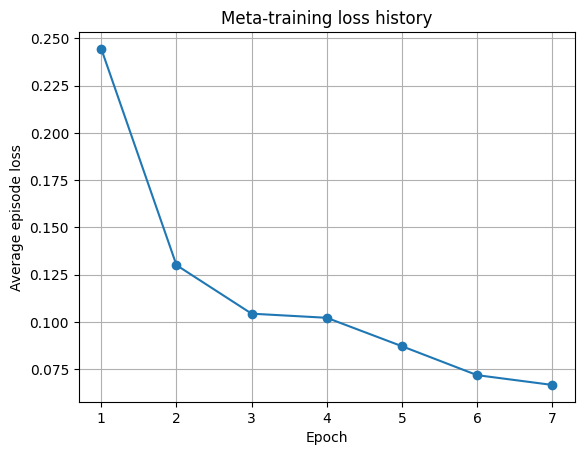

<Figure size 640x480 with 0 Axes>

In [16]:
## Plot of meta learner performance

from pathlib import Path

loss_history = np.array(loss_history)
epochs = range(1, len(loss_history) + 1)

plt.figure()
plt.plot(epochs, loss_history, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Average episode loss")
plt.title("Meta-training loss history")
plt.grid(True)
plt.show()

plt.savefig("meta_training_loss.png")

**Interpretation of the average episode loss**  
The “avg episode loss” at each epoch is the average cross-entropy error over all support–query tasks in that epoch; the fact that it steadily goes from ~0.24 to ~0.09 means that the encoder is successfully learning a feature space where prototype-based segmentation works increasingly well.

**Recap episodes.**  
For one episode, we:

- Take (support_image, support_mask, query_image, query_mask).
- Encode support &rarr; compute prototypes (foreground/background).
- Encode query &rarr; classify each pixel using the prototypes.
- Compare predicted class vs true class at each pixel of the query.
- Compute a cross-entropy loss over all those pixels.

## 8. Few-shot inference: 1-shot and K-shot helpers

After meta-training, comes meta-learning. We want to use the encoder for **few-shot segmentation** on new data.

We define a function for that:  
- `k_shot_predict` takes:
  - `K` support images and masks, and
  - a query image,
  and returns the full-resolution logits `[1, 2, H, W]` for the query.
- Internally, it encodes supports and query, computes prototypes using all K supports, classifies the query at the feature resolution, and upsamples the logits back to the original image size.

For convenience, `one_shot_predict` wraps this function for the special case `K = 1`. These utilities are used both for quantitative evaluation and for visualising qualitative results.

In [17]:
# ============================================================
# 9. Few-shot inference on test images
# ============================================================


def k_shot_predict(encoder, support_imgs, support_masks, query_img):
    """
    K-shot segmentation for a query image given K support images+masks.

    support_imgs:  [K, 3, H, W]
    support_masks: [K, 1, H, W]
    query_img:     [3, H, W]
    Returns: logits [1, 2, H, W]
    """
    encoder.eval()
    with torch.no_grad():
        support_imgs = support_imgs.to(device)  # [K,3,H,W]
        support_masks = support_masks.to(device)  # [K,1,H,W]
        query_img = query_img.to(device).unsqueeze(0)  # [1,3,H,W]

        # Pass through encoder
        feat_s = encoder(support_imgs)  # [K,C,H',W']
        feat_q = encoder(query_img)  # [1,C,H',W']

        # Compute prototypes
        prototypes = compute_prototypes(feat_s, support_masks)  # [2,C]

        # Classify query pixels
        logits_small = classify_query(feat_q, prototypes)  # [1,2,H',W']
        logits = F.interpolate(
            logits_small,
            size=(query_img.shape[2], query_img.shape[3]),
            mode="bilinear",
            align_corners=False,
        )  # [1,2,H,W]

    return logits.cpu()


def one_shot_predict(encoder, support_img, support_mask, query_img):
    """
    1-shot helper that wraps single support into K=1 form.
    """
    support_imgs = support_img.unsqueeze(0)  # [1,3,H,W]
    support_masks = support_mask.unsqueeze(0)  # [1,1,H,W]
    return k_shot_predict(encoder, support_imgs, support_masks, query_img)

# 9. Results and discussion

## 9.1. Quantitative evaluation: K-shot IoU

To assess the model, we evaluate **K-shot IoU** on the test split:

- For each test image (query), we randomly sample `K` distinct support images from the training split.
- We run `k_shot_predict` to obtain predicted logits and compute IoU with respect to the true rooftop mask.
- We repeat this process for multiple random test queries and report the **mean and standard deviation of IoU**.

By varying `K` we can study how performance improves as we provide more labelled examples to the model.


In [18]:
# ============================================================
# 9a. K-shot inference on test images
# ============================================================

import numpy as np
import torch


def evaluate_kshot_iou(encoder, train_dataset, test_dataset, K=5, num_samples=None):
    """
    Evaluate K-shot IoU on 'num_samples' random test images.
    For each test image, randomly sample K *distinct* support images from the train set.
    """
    encoder.eval()
    rng = np.random.default_rng(42)

    # If num_samples is None, evaluate on all test samples
    if num_samples is None:
        num_samples = len(test_dataset)

    ious = []
    for _ in range(num_samples):
        # pick random test index
        ti = rng.integers(0, len(test_dataset))
        img_q, mask_q = test_dataset[ti]

        # pick K distinct support indices
        support_indices = rng.choice(len(train_dataset), size=K, replace=False)
        support_imgs = []
        support_masks = []
        for si in support_indices:
            img_s, mask_s = train_dataset[si]
            support_imgs.append(img_s)
            support_masks.append(mask_s)
        support_imgs = torch.stack(support_imgs, dim=0)  # [K,3,H,W]
        support_masks = torch.stack(support_masks, dim=0)  # [K,1,H,W]

        # run K-shot prediction
        logits = k_shot_predict(encoder, support_imgs, support_masks, img_q)  # [1,2,H,W]

        iou = iou_from_logits(logits, mask_q.unsqueeze(0))
        ious.append(iou)

    ious = np.array(ious)
    print(f"{K}-shot mean IoU over {num_samples} test samples: {ious.mean():.3f}")
    return ious

## 9.2. Visualising a 1-shot episode

1. Randomly sample a support image and mask from the training set.
2. Randomly sample a query image and mask from the test set.
3. Run `one_shot_predict` to obtain the predicted query mask.
4. Plot:
   - the support image and its mask,
   - the query image and its ground-truth mask,
   - and the predicted mask.

This helps build intuition about where the model succeeds or fails—for example, whether it captures rooftop shapes well and where it confuses rooftops with other bright surfaces.

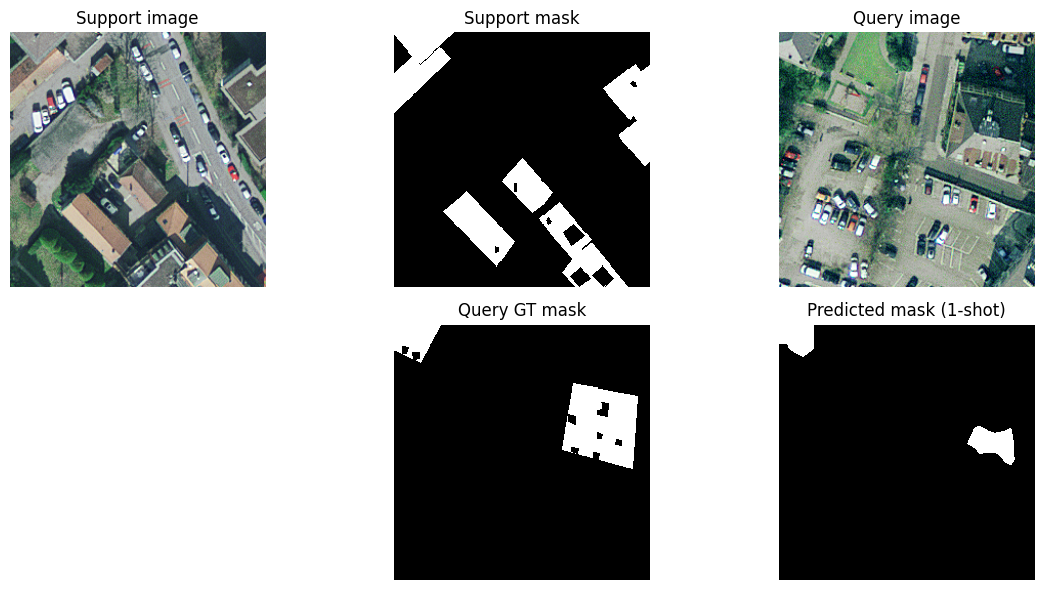

In [19]:
def tensor_to_rgb(img_tensor):
    """Undo normalisation and convert [3,H,W] tensor to [H,W,3] RGB numpy."""
    img_np = img_tensor.detach().cpu().permute(1, 2, 0).numpy()
    img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_np = np.clip(img_np, 0, 1)
    return img_np


def visualise_few_shot_example(encoder, train_dataset, test_dataset):
    encoder.eval()
    rng = np.random.default_rng()

    # pick support from train, query from test
    si = rng.integers(0, len(train_dataset))
    ti = rng.integers(0, len(test_dataset))

    img_s, mask_s = train_dataset[si]
    img_q, mask_q = test_dataset[ti]

    logits = one_shot_predict(encoder, img_s, mask_s, img_q)  # [1,2,H,W]
    pred_mask = logits.argmax(dim=1, keepdim=True).float().squeeze(0).squeeze(0).numpy()

    # convert to numpy for plotting
    img_s_np = tensor_to_rgb(img_s)
    img_q_np = tensor_to_rgb(img_q)
    mask_s_np = mask_s.squeeze(0).numpy()
    mask_q_np = mask_q.squeeze(0).numpy()

    plt.figure(figsize=(12, 6))

    plt.subplot(2, 3, 1)
    plt.imshow(img_s_np)
    plt.title("Support image")
    plt.axis("off")

    plt.subplot(2, 3, 2)
    plt.imshow(mask_s_np, cmap="gray")
    plt.title("Support mask")
    plt.axis("off")

    plt.subplot(2, 3, 3)
    plt.imshow(img_q_np)
    plt.title("Query image")
    plt.axis("off")

    plt.subplot(2, 3, 5)
    plt.imshow(mask_q_np, cmap="gray")
    plt.title("Query GT mask")
    plt.axis("off")

    plt.subplot(2, 3, 6)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Predicted mask (1-shot)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


visualise_few_shot_example(encoder, train_base, test_base)

## 9.3. Visualising a K-shot episode

Finally, we visualise a **K-shot** episode (e.g. 5-shot) to complement the numerical results:

1. Select a random query image from the test set.
2. Select `K` random support images from the training set.
3. Run `k_shot_predict` to produce a predicted mask.
4. Plot:
   - the query image,
   - the ground-truth query mask,
   - and the K-shot predicted mask.

Qualitatively comparing this to the 1-shot visualisation helps us see where additional support images improve the segmentation—typically in challenging cases such as partially occluded rooftops or unusual roof materials.


## 9.4. Comparing 1-shot and 5-shot performance

Using the evaluation function above, we can now compare:

- **1-shot IoU**, where only a single annotated support image is available, and
- **5-shot IoU**, where we provide five labelled support images for each test query.

We expect performance to improve with more support examples, as the prototypes become more representative of the diversity of rooftop appearances. This experiment illustrates a key trade-off in few-shot learning between **annotation cost** (how many labelled examples we need) and **model performance**.


In [20]:
# ============================================================
# 9d. K-shot inference on test images
# ============================================================

# 1-shot using the same function
ious_1shot = evaluate_kshot_iou(encoder, train_base, test_base, K=1, num_samples=None)

# 5-shot
ious_5shot = evaluate_kshot_iou(encoder, train_base, test_base, K=5, num_samples=None)

# 10-shot
ious_10shot = evaluate_kshot_iou(encoder, train_base, test_base, K=10, num_samples=None)

# 20-shot
ious_20shot = evaluate_kshot_iou(encoder, train_base, test_base, K=20, num_samples=None)

1-shot mean IoU over 102 test samples: 0.493
5-shot mean IoU over 102 test samples: 0.485
10-shot mean IoU over 102 test samples: 0.486
20-shot mean IoU over 102 test samples: 0.497


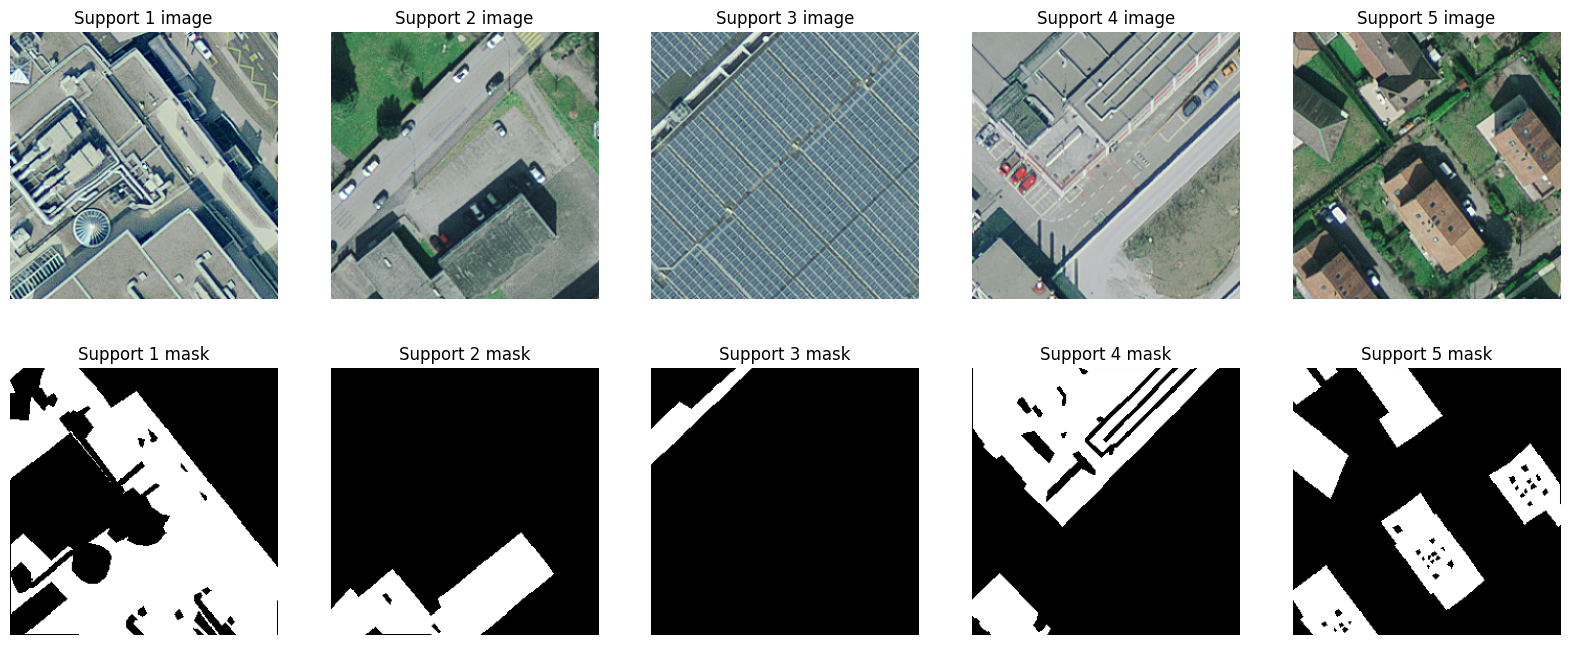

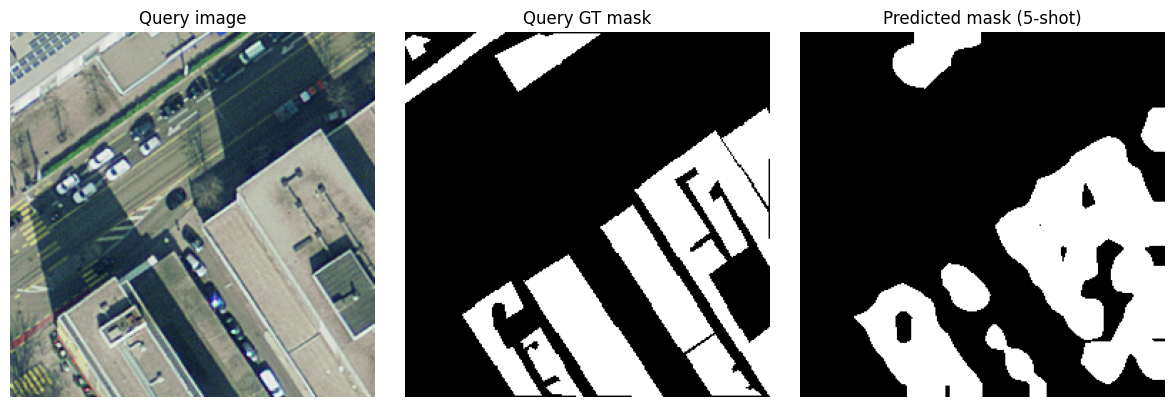

<Figure size 640x480 with 0 Axes>

In [24]:
def visualise_kshot_example(encoder, train_dataset, test_dataset, K=5):
    encoder.eval()
    rng = np.random.default_rng()

    # pick query from test
    ti = rng.integers(0, len(test_dataset))
    img_q, mask_q = test_dataset[ti]

    # pick K supports from train
    support_indices = rng.choice(len(train_dataset), size=K, replace=False)
    support_imgs, support_masks = [], []
    for si in support_indices:
        img_s, mask_s = train_dataset[si]
        support_imgs.append(img_s)
        support_masks.append(mask_s)
    support_imgs = torch.stack(support_imgs, dim=0)  # [K,3,H,W]
    support_masks = torch.stack(support_masks, dim=0)  # [K,1,H,W]

    # prediction
    logits = k_shot_predict(encoder, support_imgs, support_masks, img_q)
    pred_mask = logits.argmax(dim=1, keepdim=True).float().squeeze().numpy()

    img_q_np = tensor_to_rgb(img_q)
    mask_q_np = mask_q.squeeze(0).numpy()

    # Plot
    cols = max(K, 3)
    plt.figure(figsize=(4 * cols, 8))

    # first row: support images
    for i in range(K):
        plt.subplot(2, cols, i + 1)
        plt.imshow(tensor_to_rgb(support_imgs[i]))
        plt.title(f"Support {i+1} image")
        plt.axis("off")

    # second row: support masks
    for i in range(K):
        plt.subplot(2, cols, cols + i + 1)
        plt.imshow(support_masks[i].squeeze(0).numpy(), cmap="gray")
        plt.title(f"Support {i+1} mask")
        plt.axis("off")

    # query image & masks to the right (replace last columns if needed)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img_q_np)
    plt.title("Query image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask_q_np, cmap="gray")
    plt.title("Query GT mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap="gray")
    plt.title(f"Predicted mask ({K}-shot)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


# Example 5-shot visualisation
visualise_kshot_example(encoder, train_base, test_base, K=5)

plt.savefig("predicted_masks.png")

## 9.5. Discussion

COMPLETE HERE
Ideas:
- difference normal ResNet and pretrained ResNet
- the slow performance increase with higher k 
- general implications of few-shot for our usecase: are other methods more suitable?

## 10. References

- Alsentzer, E., Li, M. M., Kobren, S. N., Noori, A., Undiagnosed Diseases Network, Kohane, I. S., & Zitnik, M. (2025). *Few shot learning for phenotype-driven diagnosis of patients with rare genetic diseases*. **npj Digital Medicine, 8**(1), 380. https://doi.org/10.1038/s41746-025-01749-1

- Castello, R., Walch, A., Attias, R., Cadei, R., Jiang, S., & Scartezzini, J.-L. (2021). *Quantification of the suitable rooftop area for solar panel installation from overhead imagery using convolutional neural networks*. **Journal of Physics: Conference Series, 2042**(1), 012002. https://doi.org/10.1088/1742-6596/2042/1/012002

- Chen, Y., Wei, C., Wang, D., Ji, C., & Li, B. (2022). *Semi-supervised contrastive learning for few-shot segmentation of remote sensing images*. **Remote Sensing, 14**(17), 4254. https://doi.org/10.3390/rs14174254

- Finn, C., Abbeel, P., & Levine, S. (2017). *Model-agnostic meta-learning for fast adaptation of deep networks*. In **International Conference on Machine Learning** (pp. 1126–1135). PMLR. https://doi.org/10.48550/arXiv.1703.03400

- Ge, Z., Fan, X., Zhang, J., & Jin, S. (2025). *SegPPD-FS: Segmenting plant pests and diseases in the wild using few-shot learning*. **Plant Phenomics**, 100121. https://doi.org/10.1016/j.plaphe.2025.100121

- Hu, Y., Liu, C., Li, Z., Xu, J., Han, Z., & Guo, J. (2022). *Few-shot building footprint shape classification with relation network*. **ISPRS International Journal of Geo-Information, 11**(5), 311. https://doi.org/10.3390/ijgi11050311

- Jadon, S. (2021, February). *COVID-19 detection from scarce chest x-ray image data using few-shot deep learning approach*. In **Medical Imaging 2021: Imaging Informatics for Healthcare, Research, and Applications** (Vol. 11601, pp. 161–170). SPIE. https://doi.org/10.1117/12.2581496

- Lee, G. Y., Dam, T., Ferdaus, M. M., Poenar, D. P., & Duong, V. (2025). *Enhancing Few-Shot Classification of Benchmark and Disaster Imagery with ATTBHFA-Net*. **arXiv preprint arXiv:2510.18326**. https://doi.org/10.48550/arXiv.2510.18326

- Li, X., He, Z., Zhang, L., Guo, S., Hu, B., & Guo, K. (2025). *CDCNet: Cross-domain few-shot learning with adaptive representation enhancement*. **Pattern Recognition, 162**, 111382. https://doi.org/10.1016/j.patcog.2025.111382

- Puthumanaillam, G., & Verma, U. (2023). *Texture based prototypical network for few-shot semantic segmentation of forest cover: Generalizing for different geographical regions*. **Neurocomputing, 538**, 126201. https://doi.org/10.1016/j.neucom.2023.03.062

- Snell, J., Swersky, K., & Zemel, R. (2017). *Prototypical networks for few-shot learning*. **Advances in Neural Information Processing Systems, 30**. https://doi.org/10.48550/arXiv.1703.05175

- Sung, F., Yang, Y., Zhang, L., Xiang, T., Torr, P. H., & Hospedales, T. M. (2018). *Learning to compare: Relation network for few-shot learning*. In **Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition** (pp. 1199–1208). https://doi.org/10.1109/CVPR.2018.00131
